# Generating stimuli for A/B choice experiment, given_subgoal experiment

Purpose of this notebook is:
* to create a set of towers
* for each tower, create a tree of branching subgoal choices, which each subgoal on each turn being either the cheapest or the most expensive one meeting a certain condition.
    * ensuring that each node has a path to the goal (can we do that?)
* visualize the different choices
* create a list of **subgoals** with an associated world state, not necessarily the best and worst sequence.
* save that out to a pickled dataframe for the upload notebook in the `_human_expperiment` repo

Requires:
*

See also:
* 

## Setup

In [31]:
# set up imports
import os
import sys

__file__ = os.getcwd()
proj_dir = os.path.dirname(os.path.realpath(__file__))
sys.path.append(proj_dir)
utils_dir = os.path.join(proj_dir, "utils")
sys.path.append(utils_dir)
analysis_dir = os.path.join(proj_dir, "analysis")
analysis_utils_dir = os.path.join(analysis_dir, "utils")
sys.path.append(analysis_utils_dir)
agent_dir = os.path.join(proj_dir, "model")
sys.path.append(agent_dir)
agent_util_dir = os.path.join(agent_dir, "utils")
sys.path.append(agent_util_dir)
experiments_dir = os.path.join(proj_dir, "experiments")
sys.path.append(experiments_dir)
df_dir = os.path.join(proj_dir, "results/dataframes")
stim_dir = os.path.join(proj_dir, "stimuli")

In [32]:
import tower_generator

from tqdm import tqdm
import p_tqdm

import datetime

import pickle

import math

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import scipy.stats as stats
from scipy.stats import sem as sem

from scoping_simulations.utils.blockworld_library import *
from scoping_simulations.utils.blockworld import *

from scoping_simulations.model.BFS_Lookahead_Agent import BFS_Lookahead_Agent
from scoping_simulations.model.BFS_Agent import BFS_Agent
from scoping_simulations.model.Astar_Agent import Astar_Agent
from scoping_simulations.model.Best_First_Search_Agent import Best_First_Search_Agent
from scoping_simulations.model.Subgoal_Planning_Agent import Subgoal_Planning_Agent

from scoping_simulations.model.utils.decomposition_functions import *
import scoping_simulations.utils.blockworld_library as bl

In [33]:
# used for naming the output file
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

Usually we would fix the random seeds here, but the agents are being run with fixed random seeds, so this is not necessary here.

In [34]:
# show all columns in dataframe
pd.set_option("display.max_columns", None)

## Generating towers


In [35]:
block_library = bl_nonoverlapping_simple

In [36]:
generator = tower_generator.TowerGenerator(
    8,
    8,
    block_library=block_library,
    seed=3,
    padding=(1, 0),
    num_blocks=lambda: random.randint(
        6, 18
    ),  #  flat random interval of tower sizes (inclusive)
)

In [37]:
NUM_TOWERS = 128
towers = []
for i in tqdm(range(NUM_TOWERS)):
    tower = generator.generate()
    towers.append(tower)

100%|██████████| 8/8 [00:01<00:00,  6.55it/s]


In [38]:
worlds = [
    Blockworld(silhouette=t["bitmap"], block_library=bl.bl_nonoverlapping_simple)
    for t in towers
]
worlds_sizes = [len(t["blocks"]) for t in towers]

Generate percentiles for the size of towers to select over in the experiment creation notebook

In [39]:
towersize_percentiles = [np.percentile(worlds_sizes, i) for i in [33, 66, 99]]

size_percentiles = [None] * len(worlds_sizes)
for i, cost in enumerate(worlds_sizes):
    if cost < towersize_percentiles[0]:
        size_percentiles[i] = "small"
    elif cost < towersize_percentiles[1]:
        size_percentiles[i] = "medium"
    else:
        size_percentiles[i] = "large"

In [40]:
# look at towers
def visualize_towers(towers, text_parameters=None):
    fig, axes = plt.subplots(
        math.ceil(len(towers) / 5), 5, figsize=(20, 15 * math.ceil(len(towers) / 20))
    )
    for axis, tower in zip(axes.flatten(), towers):
        axis.imshow(tower["bitmap"] * 1.0)
        if text_parameters is not None:
            if type(text_parameters) is not list:
                text_parameters = [text_parameters]
            for y_offset, text_parameter in enumerate(text_parameters):
                axis.text(
                    0,
                    y_offset * 1.0,
                    str(text_parameter + ": " + str(tower[text_parameter])),
                    color="gray",
                    fontsize=20,
                )
    plt.tight_layout()
    plt.show()

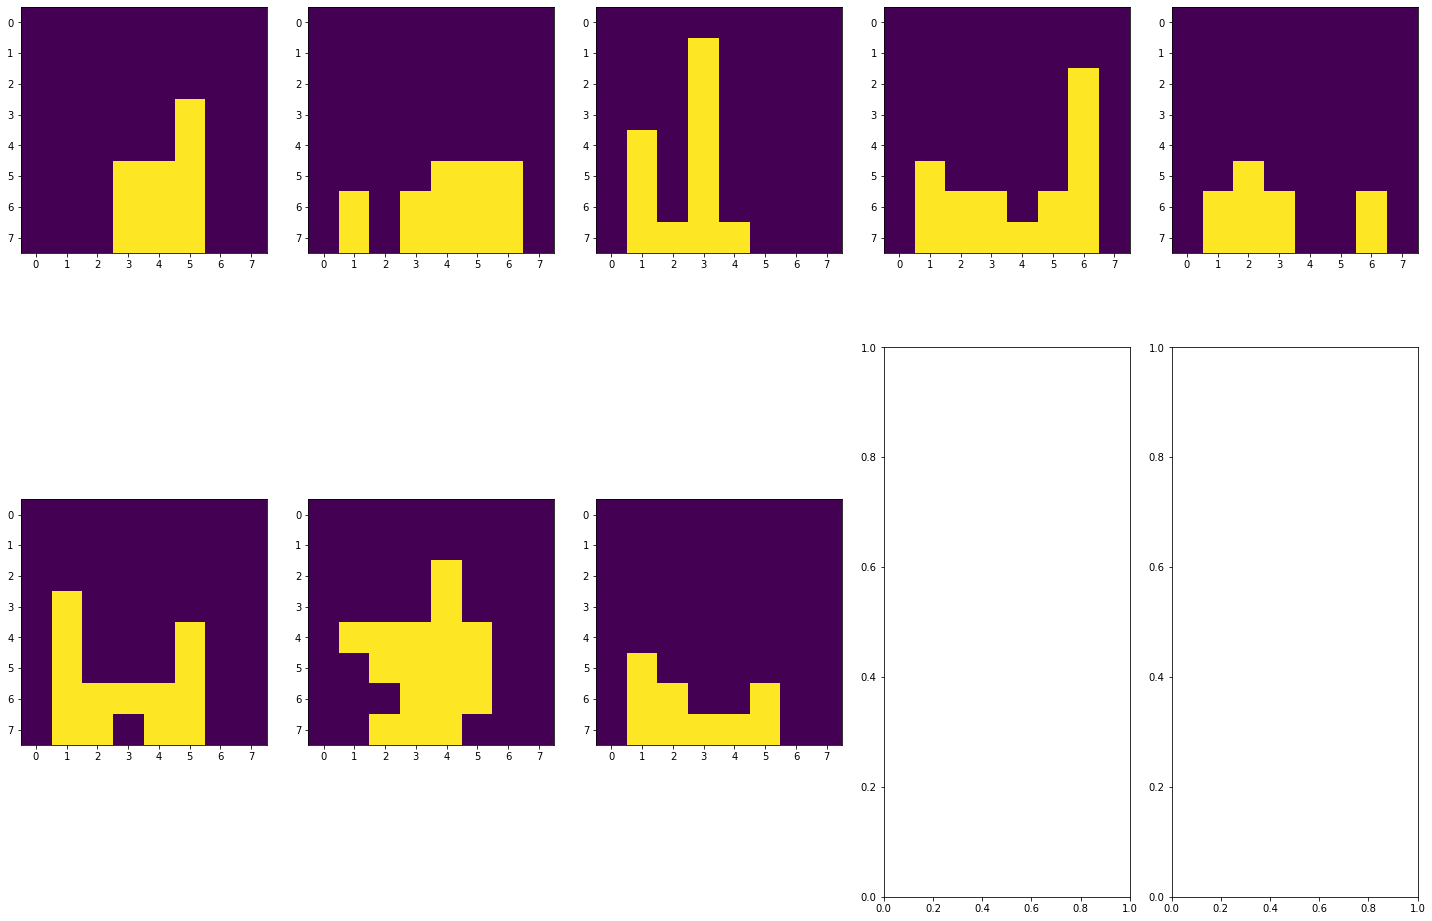

In [41]:
visualize_towers(towers)

## Score towers for basic difficulty
For each tower, compute the cost of solving it using a planning agent.

Here, we use Best First Search without lookahead or subgoals.

In [42]:
lower_agent = Best_First_Search_Agent(random_seed=42)

In [43]:
def get_tower_cost(agent, world):
    cost = 0
    agent.set_world(world)
    world.reset()
    while world.status()[0] == "Ongoing":
        _, step_info = agent.act()
        cost += step_info["states_evaluated"]
    return cost, world.status()

In [44]:
# parallelized
agents = [copy.deepcopy(a) for a in [lower_agent] * len(worlds)]

# remove process connection before handoff to the threads
for world in worlds:
    world.physics_provider.kill_server(force=True)

results = p_tqdm.p_map(get_tower_cost, agents, worlds)
costs = [c[0] for c in results]
statusses = [c[1] for c in results]

100%|██████████| 8/8 [00:02<00:00,  3.82it/s]


Split the basic costs into three percentiles: easy, medium, hard.

In [45]:
difficulty_percentiles = [np.percentile(costs, i) for i in [33, 66, 99]]

percentiles = [None] * len(costs)
for i, cost in enumerate(costs):
    if cost < difficulty_percentiles[0]:
        percentiles[i] = "easy"
    elif cost < difficulty_percentiles[1]:
        percentiles[i] = "medium"
    else:
        percentiles[i] = "hard"

## Find best and worst subgoals
We compute the full subgoal tree for each tower and extract the best and worst sequence.

Note: for the planned studies, we will use individual states and subgoals, not sequences of subgoals.

In [46]:
decomposer = Rectangular_Keyholes(
    sequence_length=3,
    necessary_conditions=[
        Area_larger_than(area=1),
        # Area_smaller_than(area=30), # used to be 21
        Mass_smaller_than(area=16),
        No_edge_rows_or_columns(),
    ],
    necessary_sequence_conditions=[
        Complete(),
        No_overlap(),
        Supported(),
    ],
)

sg_agent = Subgoal_Planning_Agent(
    lower_agent=lower_agent, random_seed=42, decomposer=decomposer
)

Calculate the subgoal tree for each tower.

In [47]:
# # parallelized
def get_subgoal_tree_from_tower(agent, world):
    world.reset()
    agent.set_world(world)
    return agent.get_subgoal_tree(only_solved_sequences=True)


agents = [copy.deepcopy(a) for a in [sg_agent] * len(worlds)]

# remove process connection before handoff to the threads
for world in worlds:
    world.physics_provider.kill_server(force=True)

trees = p_tqdm.p_map(get_subgoal_tree_from_tower, agents, worlds)

100%|██████████| 8/8 [00:55<00:00,  6.90s/it]


### Select most divergent subgoals
For each tower, select n state/subgoal combinations that are maximally divergent.

In [48]:
NUM_SGs_PER_TOWER = 4  # how many subgoals do we want to choose?

In [49]:
best_worst_subgoals = []
for tree in trees:
    best_worst_subgoals.append(
        tree.get_most_divergent_matching_pairs_of_subgoals(NUM_SGs_PER_TOWER)
    )

In [76]:
print(
    "Got {} subgoal pairs for {} towers".format(
        sum([len(x) for x in best_worst_subgoals]), len(towers)
    )
)

Got 18 subgoal pairs for 8 towers


In [53]:
# this is on the level of towers, not subgoal pairs
results = [
    {
        "world": world,
        "world name": index,
        "subgoal tree": tree,
        "cost": cost,
        "percentile": percentile,
        "best_worst_subgoals": best_worst_subgoal,
        "world_size": world_size,
        "world_size_percentile": world_size_percentile,
    }
    for world, index, tree, cost, percentile, best_worst_subgoal, world_size, world_size_percentile in zip(
        worlds,
        range(len(towers)),
        trees,
        costs,
        percentiles,
        best_worst_subgoals,
        worlds_sizes,
        size_percentiles,
    )
]

Add into df

In [77]:
df = pd.DataFrame(
    columns=[
        "world name",
        "world",
        "best subgoal",
        "worst subgoal",
        "subgoal cost delta",
        "subgoal cost ratio",
        "tower percentile",
        "state",
        "blocks",
        "world size",
        "world size percentile",
    ]
)
i = 0

# this is on the level of subgoal pairs
for r in results:
    for best_subgoal, worst_subgoal in r["best_worst_subgoals"]:
        # fill in subgoal cost delta
        delta = worst_subgoal.subgoal.solution_cost - best_subgoal.subgoal.solution_cost
        ratio = worst_subgoal.subgoal.solution_cost / best_subgoal.subgoal.solution_cost
        # fill in state from the best subgoal
        state = best_subgoal.subgoal.prior_world.current_state
        # insert into dataframe
        df.loc[i] = [
            r["world name"],
            r["world"],
            best_subgoal,
            worst_subgoal,
            delta,
            ratio,
            r["percentile"],
            state,
            state.blocks,
            r["world_size"],
            r["world_size_percentile"],
        ]
        i += 1

In [80]:
# get percentiles for subgoal size
subgoal_sizes = df["best subgoal"].apply(lambda x: np.sum(x.subgoal.bitmap > 0))

subgoal_size_percentile_bounds = [np.percentile(subgoal_sizes, i) for i in [33, 66, 99]]


def get_subgoal_size_percentile(subgoal):
    subgoal_size = np.sum(subgoal.subgoal.bitmap > 0)
    if subgoal_size < subgoal_size_percentile_bounds[0]:
        return "small"
    elif subgoal_size < subgoal_size_percentile_bounds[1]:
        return "medium"
    else:
        return "large"


df["subgoal size percentile"] = df["best subgoal"].apply(get_subgoal_size_percentile)

What is the distribution over the subgoal deltas/ratios?

<AxesSubplot:>

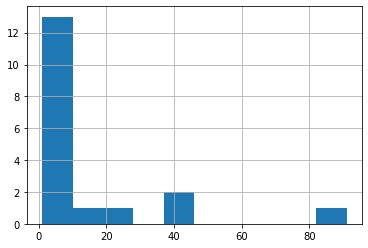

In [89]:
df["subgoal cost delta"].hist()

<AxesSubplot:>

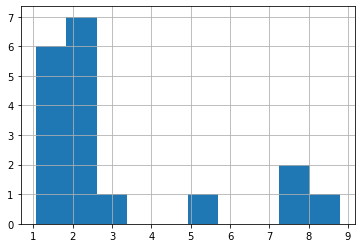

In [90]:
df["subgoal cost ratio"].hist()

What is the size of the subgoals (in number of cells)?

In [91]:
df["subgoal size"] = df["best subgoal"].apply(lambda x: np.sum(x.subgoal.bitmap > 0))
df.groupby("subgoal size percentile").describe()["subgoal size"]

,count,mean,std,min,25%,50%,75%,max
subgoal size percentile,,,,,,,,
large,6.0,17.333333,6.860515,12.0,12.75,15.0,18.75,30.0
medium,9.0,7.888889,1.900292,6.0,6.00,8.0,10.00,10.0
small,3.0,4.333333,0.577350,4.0,4.00,4.0,4.50,5.0


<AxesSubplot:>

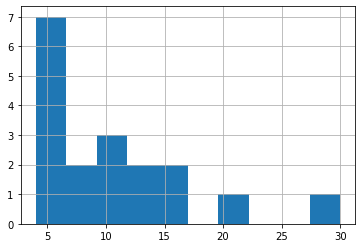

In [88]:
df["subgoal size"].hist()

Let's display some of the subgoals 

6 39


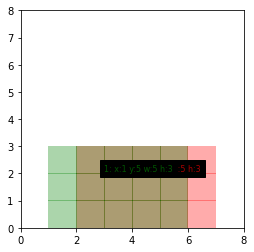

9 91


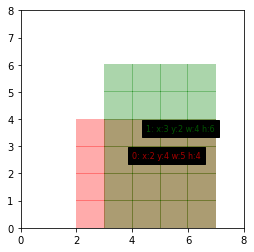

7 39


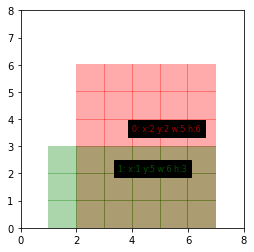

In [92]:
for i, row in df.sort_values("subgoal cost ratio", ascending=False).head(3).iterrows():
    print(i, row["subgoal cost delta"])
    # construct dummy sequence
    sequence = Subgoal_sequence([row["best subgoal"], row["worst subgoal"]])
    sequence.visual_display()

We need to assert that we only have subgoals that don't depend on previously placed blocks because reproducing blocks is not yet implemented in the experiment.

In [99]:
assert np.all(
    [
        x == []
        for x in df["best subgoal"].apply(
            lambda x: x.subgoal.prior_world.current_state.blocks
        )
    ]
), "Not at all subgoals depend on the empty world state!"

Let's save the dataframe to disk. This will serve as the basis for the `given_subgoal` human experiment.

In [101]:
df

,world name,world,best subgoal,worst subgoal,subgoal cost delta,subgoal cost ratio,tower percentile,state,blocks,world size,world size percentile,subgoal size percentile,subgoal_size,subgoal size
0,1,Blockworld,<stimuli.subgoal_tree.SubgoalTreeNode object a...,<stimuli.subgoal_tree.SubgoalTreeNode object a...,3,2.000000,easy,<utils.blockworld.Blockworld.State object at 0...,[],5,medium,medium,6,6
1,1,Blockworld,<stimuli.subgoal_tree.SubgoalTreeNode object a...,<stimuli.subgoal_tree.SubgoalTreeNode object a...,1,1.333333,easy,<utils.blockworld.Blockworld.State object at 0...,[],5,medium,medium,6,6
2,2,Blockworld,<stimuli.subgoal_tree.SubgoalTreeNode object a...,<stimuli.subgoal_tree.SubgoalTreeNode object a...,2,1.500000,hard,<utils.blockworld.Blockworld.State object at 0...,[],5,medium,small,4,4
3,2,Blockworld,<stimuli.subgoal_tree.SubgoalTreeNode object a...,<stimuli.subgoal_tree.SubgoalTreeNode object a...,3,2.000000,hard,<utils.blockworld.Blockworld.State object at 0...,[],5,medium,medium,9,9
4,2,Blockworld,<stimuli.subgoal_tree.SubgoalTreeNode object a...,<stimuli.subgoal_tree.SubgoalTreeNode object a...,7,3.333333,hard,<utils.blockworld.Blockworld.State object at 0...,[],5,medium,large,12,12
5,3,Blockworld,<stimuli.subgoal_tree.SubgoalTreeNode object a...,<stimuli.subgoal_tree.SubgoalTreeNode object a...,3,1.750000,hard,<utils.blockworld.Blockworld.State object at 0...,[],6,large,medium,8,8
6,3,Blockworld,<stimuli.subgoal_tree.SubgoalTreeNode object a...,<stimuli.subgoal_tree.SubgoalTreeNode object a...,39,8.800000,hard,<utils.blockworld.Blockworld.State object at 0...,[],6,large,large,15,15
7,3,Blockworld,<stimuli.subgoal_tree.SubgoalTreeNode object a...,<stimuli.subgoal_tree.SubgoalTreeNode object a...,39,7.500000,hard,<utils.blockworld.Blockworld.State object at 0...,[],6,large,large,30,30
8,3,Blockworld,<stimuli.subgoal_tree.SubgoalTreeNode object a...,<stimuli.subgoal_tree.SubgoalTreeNode object a...,4,2.333333,hard,<utils.blockworld.Blockworld.State object at 0...,[],6,large,medium,6,6
9,3,Blockworld,<stimuli.subgoal_tree.SubgoalTreeNode object a...,<stimuli.subgoal_tree.SubgoalTreeNode object a...,91,8.000000,hard,<utils.blockworld.Blockworld.State object at 0...,[],6,large,large,20,20


In [ ]:
df.to_pickle("most divergent subgoals {}.pkl".format(date))
print('Saved to "most divergent subgoals {}.pkl"'.format(date))